In [1]:
import sys
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [11, 5]

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

PROJECT_DIR = '..'
if PROJECT_DIR not in sys.path:
    sys.path.insert(0, PROJECT_DIR)

from tadkit.base import TADLearner
from tadkit.catalog.formalizers import PandasFormalizer

## Synthetic data simulation

In [2]:
from tadkit.utils.synthetic_ornstein_uhlenbeck import synthetise_ornstein_uhlenbeck_data
X, y = synthetise_ornstein_uhlenbeck_data(n_rows=1000, n_cols_x=5)

<Axes: >

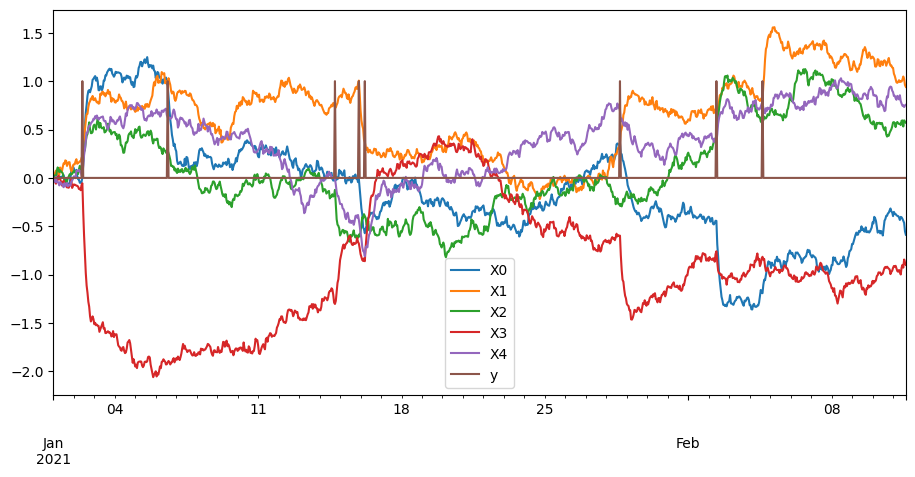

In [3]:
pd.concat((X, y), axis=1).plot()

<Axes: >

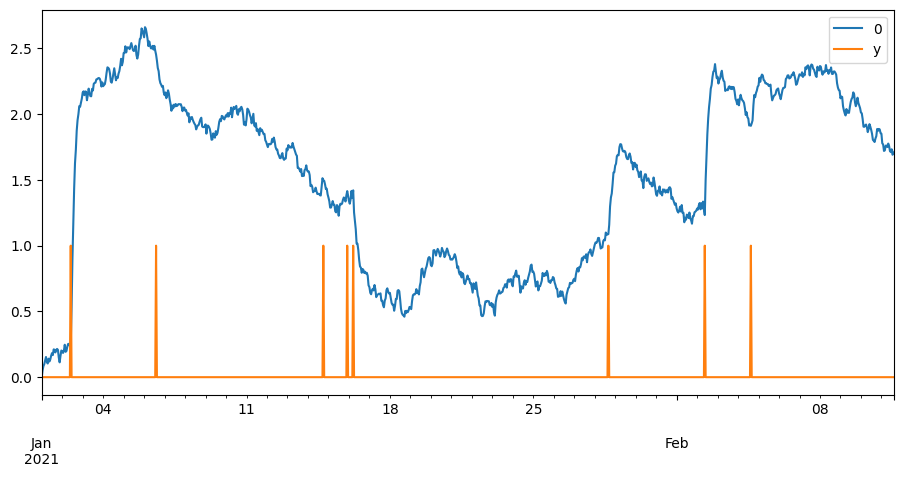

In [4]:
pd.concat([((X ** 2).sum(axis=1) ** .5), y], axis=1).plot()

# Formalizer

In [5]:
formalizer = PandasFormalizer(
        data_df=X,
        dataframe_type="synchronous",
    )

In [6]:
formalizer.available_properties

['pandas', 'fixed_time_step']

In [7]:
pprint(formalizer.query_description)

{'resampling': {'default': False,
                'description': 'Resampling of the target query',
                'family': 'bool'},
 'resampling_resolution': {'default': 120,
                           'description': 'If resampling, resampling '
                                          'resolution in seconds.',
                           'family': 'time',
                           'start': 60,
                           'stop': 3600},
 'target_period': {'default': (Timestamp('2021-01-01 00:00:00'),
                               Timestamp('2021-02-11 15:00:00')),
                   'description': 'Time period for your query.',
                   'family': 'time_interval',
                   'start': Timestamp('2021-01-01 00:00:00'),
                   'stop': Timestamp('2021-02-11 15:00:00')},
 'target_space': {'default': Index(['X0', 'X1', 'X2', 'X3', 'X4'], dtype='object'),
                  'description': 'List of sensors used for your query.',
                  'family': 'space

In [8]:
formalizer.formalize(data=X, columns_0=['X1', 'X2'],
                     time_interval=['2021-01-01 02:00:00', '2021-02-02'],
                     target_space=X.columns,
                     resampling=True,
                     resampling_resolution=60)

X0        X1        X2        X3        X4
2021-01-01 00:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
2021-01-01 00:01:00  0.000088  0.000412  0.000449 -0.000373 -0.000491
2021-01-01 00:02:00  0.000175  0.000824  0.000898 -0.000745 -0.000982
2021-01-01 00:03:00  0.000263  0.001236  0.001348 -0.001118 -0.001473
2021-01-01 00:04:00  0.000350  0.001649  0.001797 -0.001491 -0.001964
...                       ...       ...       ...       ...       ...
2021-02-11 14:56:00 -0.584958  0.942160  0.571343 -0.897471  0.755402
2021-02-11 14:57:00 -0.585516  0.941845  0.571196 -0.897901  0.755519
2021-02-11 14:58:00 -0.586074  0.941530  0.571048 -0.898330  0.755637
2021-02-11 14:59:00 -0.586633  0.941214  0.570901 -0.898760  0.755755
2021-02-11 15:00:00 -0.587191  0.940899  0.570754 -0.899189  0.755873

[59941 rows x 5 columns]

# Learners

In [13]:
print(isinstance(IsolationForest, TADLearner))
from tadkit.utils.tadlearner_factory import tadlearner_factory
IsolationForestLearner = tadlearner_factory(IsolationForest, [], {})
print(isinstance(IsolationForestLearner, TADLearner))

False
True


StandardScalerIsolationForest()

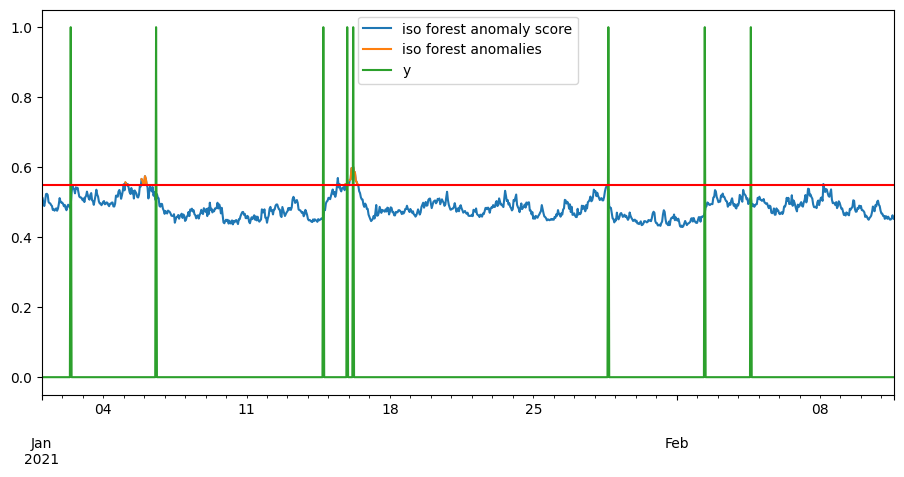

In [14]:
from tadkit.utils.decomposable_tadlearner import decomposable_tadlearner_factory

StandardForestLearner = decomposable_tadlearner_factory(StandardScaler, IsolationForestLearner, [], {})
learner = StandardForestLearner()
learner.random_state = -1
learner.fit(X)
anom_score = -learner.score_samples(X)

iso_score = pd.DataFrame(anom_score, index=X.index, columns=["iso forest anomaly score"])

ceil = .55

iso_anomalies = iso_score[iso_score > ceil]
iso_anomalies.rename(columns={"iso forest anomaly score": "iso forest anomalies"}, inplace=True)

pd.concat([iso_score, iso_anomalies, y], axis=1).plot()
plt.axhline(y=ceil, color='r', linestyle='-')
learner

In [15]:
class ExponantialMean:
    def __init__(self, lags, sub_X=False) -> None:
        self.lags = np.array(lags)
        self.sub_X = sub_X
        assert sum(d != 1 for d in self.lags.shape) <= 1
        self.lags = self.lags.reshape(-1)

    def transform(self, X):
        lags_len, = self.lags.shape
        index = X.index
        columns = sum(
            ([f'{colname}_ema{i}' for i in range(lags_len)] for colname in X.columns),
            start=[]
        )
        t = index.astype('int64') * 1e-9
        X = X.values
        n, d = X.shape
        result = np.empty((n, d, lags_len))
        result[0] = X[0, :, None]
        for i in range(n-1):
            weight = np.exp(-(t[i+1] - t[i]) / self.lags)[None, None]
            result[i+1] = result[i] * weight + X[i+1, :, None] * (1 - weight)
        if self.sub_X:
            result -= X[:, :, None]
        result = pd.DataFrame(
            result.reshape((n, -1)),
            index=index,
            columns=columns
        )
        return result

In [16]:
MINUTE = 60
HOUR = 60 * MINUTE
DAY = 24 * HOUR
exponential_mean = ExponantialMean([DAY, 3* DAY], sub_X=True)
exponential_mean.transform(X)

X0_ema0   X0_ema1   X1_ema0   X1_ema1   X2_ema0  \
2021-01-01 00:00:00  0.000000  0.000000  0.000000  0.000000  0.000000   
2021-01-01 01:00:00 -0.005038 -0.005180 -0.023719 -0.024387 -0.025852   
2021-01-01 02:00:00 -0.031711 -0.032745 -0.048762 -0.050794 -0.001294   
2021-01-01 03:00:00 -0.015200 -0.016647 -0.069807 -0.073777 -0.007043   
2021-01-01 04:00:00 -0.067253 -0.070574 -0.048571 -0.053855 -0.062409   
...                       ...       ...       ...       ...       ...   
2021-02-11 11:00:00 -0.051206 -0.211574  0.117038  0.144954 -0.001470   
2021-02-11 12:00:00 -0.028717 -0.187681  0.081779  0.111612  0.058907   
2021-02-11 13:00:00 -0.007902 -0.164897  0.104148  0.136504 -0.004352   
2021-02-11 14:00:00  0.077915 -0.074720  0.158832  0.195215  0.010635   
2021-02-11 15:00:00  0.106862 -0.040657  0.170498  0.211182  0.018675   

                      X2_ema1   X3_ema0   X3_ema1   X4_ema0   X4_ema1  
2021-01-01 00:00:00  0.000000  0.000000  0.000000  0.000000  0.000000  
2021-01-01 01:00:00 -0.026580  0.021447  0.022051  0.028259  0.029055  
2021-01-01 02:00:00 -0.002048  0.037732  0.039390  0.037896  0.039748  
2021-01-01 03:00:00 -0.007985  0.054845  0.058025 -0.014293 -0.012868  
2021-01-01 04:00:00 -0.065097  0.030707  0.034709  0.041473  0.044046  
...                       ...       ...       ...       ...       ...  
2021-02-11 11:00:00  0.090219 -0.091695 -0.115633  0.091504  0.073529  
2021-02-11 12:00:00  0.150990 -0.060468 -0.085780  0.081817  0.066394  
2021-02-11 13:00:00  0.086338 -0.138787 -0.167659  0.096796  0.084312  
2021-02-11 14:00:00  0.100374 -0.104210 -0.135619  0.077579  0.067452  
2021-02-11 15:00:00  0.107702 -0.075242 -0.108337  0.067626  0.059545  

[1000 rows x 10 columns]

In [17]:
EMAForestLearner = decomposable_tadlearner_factory(ExponantialMean, IsolationForestLearner, [], {
    'lags': {
        'description': 'Lags typical time of exponential mean',
        'family': 'preprossing',
        'value_type': 'set',
        'start': 0,
    },
    'sub_X': {
        'description': 'Value substract from to the lags',
        'family': 'preprossing',
        'value_type': 'bool',
    },
})
learner = EMAForestLearner(lags=np.geomspace(.1 * DAY, 2 * DAY, 10), sub_X=True)
learner.random_state = -1
learner.fit(X)
anom_score = -learner.score_samples(X)
ema_score = pd.DataFrame(anom_score, index=X.index, columns=["ema iso forest anomaly score"])

ceil = .5

ema_anomalies = ema_score[iso_score > ceil]
ema_anomalies.rename(columns={"ema iso forest anomaly score": "ema iso forest anomalies"}, inplace=True)

learner

ExponantialMeanIsolationForest()

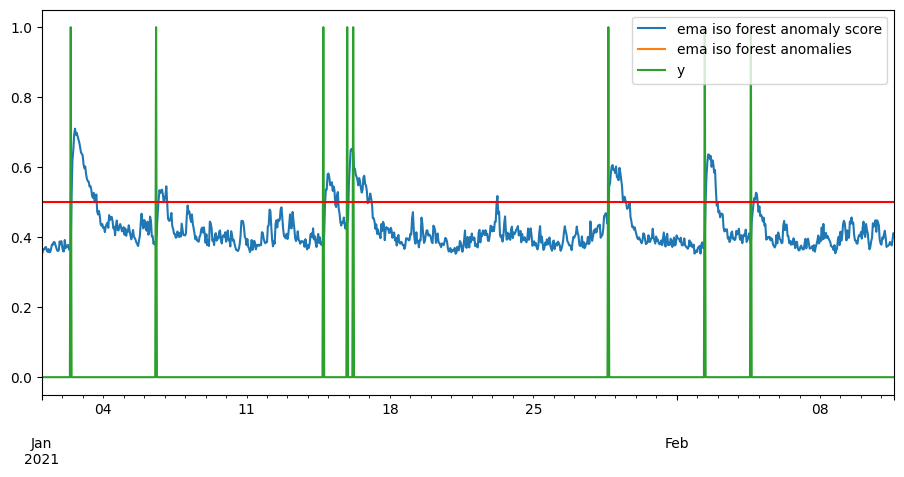

In [18]:
pd.concat([ema_score, ema_anomalies, y], axis=1).plot()
plt.axhline(y=ceil, color='r', linestyle='-')